In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
netflix = pd.read_csv('netflix_titles.csv')

In [7]:
netflix.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4747,s4748,TV Show,Kath and Kim,NaN,"Jane Turner, Gina Riley, Glenn Robbins, Peter ...",Australia,"July 28, 2018",2007,TV-MA,6 Seasons,TV Comedies,As Kath prepares to wed fine-meats purveyor Ke...
4228,s4229,Movie,Whitney Cummings: Money Shot,John Fortenberry,Whitney Cummings,United States,"January 1, 2019",2010,TV-MA,48 min,Stand-Up Comedy,Comedy Central roast veteran Whitney Cummings ...
5371,s5372,Movie,Aditi Mittal: Things They Wouldn't Let Me Say,Fazila Allana,Aditi Mittal,India,"July 18, 2017",2017,TV-MA,63 min,Stand-Up Comedy,Trailblazing comic Aditi Mittal mixes topical ...
3536,s3537,Movie,Saawan,Farhan Alam,"Karam Hussain, Arif Bahlim, Najiba Faiz, Salee...",Pakistan,"September 4, 2019",2016,TV-14,128 min,"Dramas, Independent Movies, International Movies",Outcast from society and left to die in the wi...
4694,s4695,Movie,Toilet: Ek Prem Katha,Shree Narayan Singh,"Akshay Kumar, Bhumi Pednekar, Divyendu Sharma,...",India,"August 21, 2018",2017,TV-14,145 min,"Comedies, Dramas, International Movies","On her first day of marriage, a woman leaves h..."


In [8]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [9]:
netflix.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [10]:
new_netflix = netflix.copy()

In [11]:
new_netflix.director.fillna("Unknown",inplace = True)
new_netflix.cast.fillna("Unknown", inplace = True)
new_netflix.country.fillna("Unknown", inplace = True)

In [12]:
new_netflix.date_added.mode()

0    January 1, 2020
Name: date_added, dtype: object

In [13]:
new_netflix['date_added'] = new_netflix['date_added'].str.strip()
new_netflix.date_added.fillna("January 1, 2020", inplace = True)
new_netflix['date_added'] = pd.to_datetime(new_netflix['date_added'])

In [14]:
new_netflix[new_netflix.duration.isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,2017-04-04,2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,2016-09-16,2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,2016-08-15,2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


In [15]:
new_netflix['duration'] = np.where(new_netflix.duration.isna(), new_netflix['rating'], new_netflix['duration'])

In [16]:
new_netflix.rating.mode()

0    TV-MA
Name: rating, dtype: object

In [17]:
new_netflix['rating'].replace('min',np.nan,inplace=True, regex=True)

In [18]:
new_netflix.rating.fillna("TV-MA", inplace = True)

In [19]:
new_netflix.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [20]:
new_netflix.duplicated().sum()

0

In [21]:
new_netflix.show_id.is_unique

True

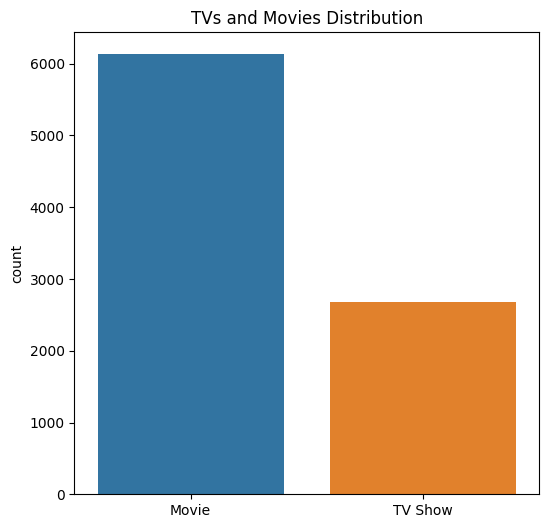

In [22]:
#TVs and Movies Distribution 

plt.figure(figsize=(6,6))
plt.title("TVs and Movies Distribution")
#p = plt.bar(new_netflix.type.unique(), new_netflix.type.value_counts())
p = sns.barplot(data = new_netflix, x = new_netflix.type.unique(), y = new_netflix.type.value_counts())
plt.show()

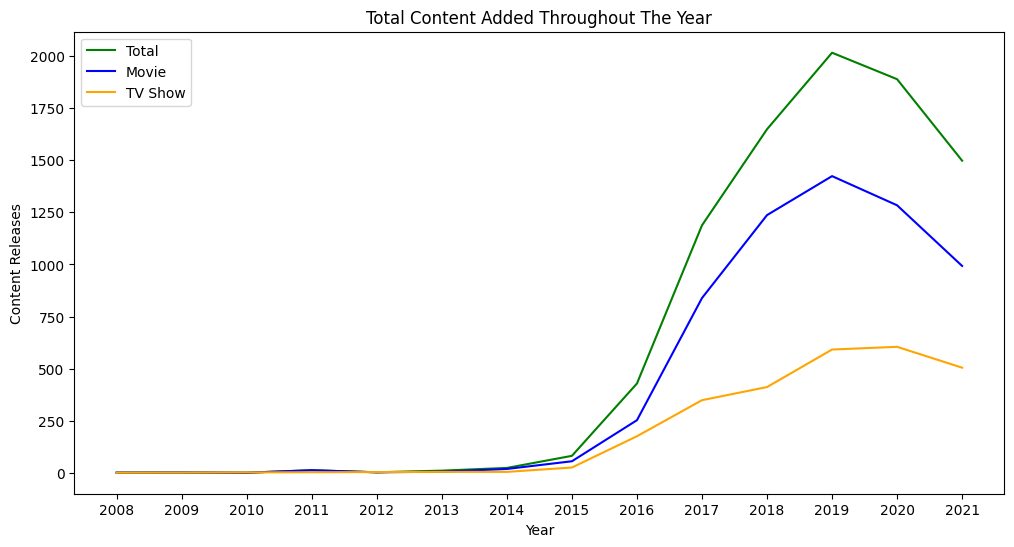

In [23]:
#Total Content Added Throughout The Year

movie_df = new_netflix[new_netflix['type'] == 'Movie']
tv_df = new_netflix[new_netflix['type'] == 'TV Show']

total = new_netflix.date_added.dt.year.value_counts().to_frame().reset_index()
movie = movie_df.date_added.dt.year.value_counts().to_frame().reset_index()
tv = tv_df.date_added.dt.year.value_counts().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=total, x='date_added', y='count', label = 'Total' , color='green')
sns.lineplot(data=movie, x='date_added', y='count', label = 'Movie', color='blue')
sns.lineplot(data=tv, x='date_added', y='count', label = 'TV Show', color='orange')
ax.set_xticks(np.arange(2008, 2022, 1))
plt.title("Total Content Added Throughout The Year")
plt.ylabel("Content Releases")
plt.xlabel("Year")
plt.show()

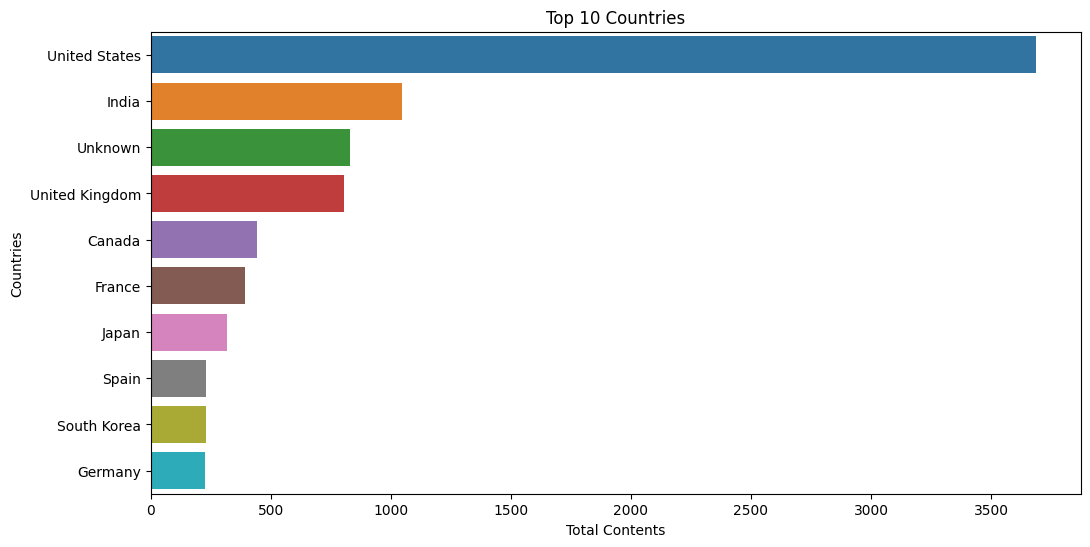

In [24]:
# Top 10 Countries 

filter_country = new_netflix[new_netflix['country']!='Unknown']
filter_country = new_netflix.set_index('title').country.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

plt.figure(figsize=(12,6))
plt.title("Top 10 Countries")
g = sns.countplot(y = filter_country, order=filter_country.value_counts().index[:10])
g.set(xlabel='Total Contents',ylabel='Countries')
plt.show()

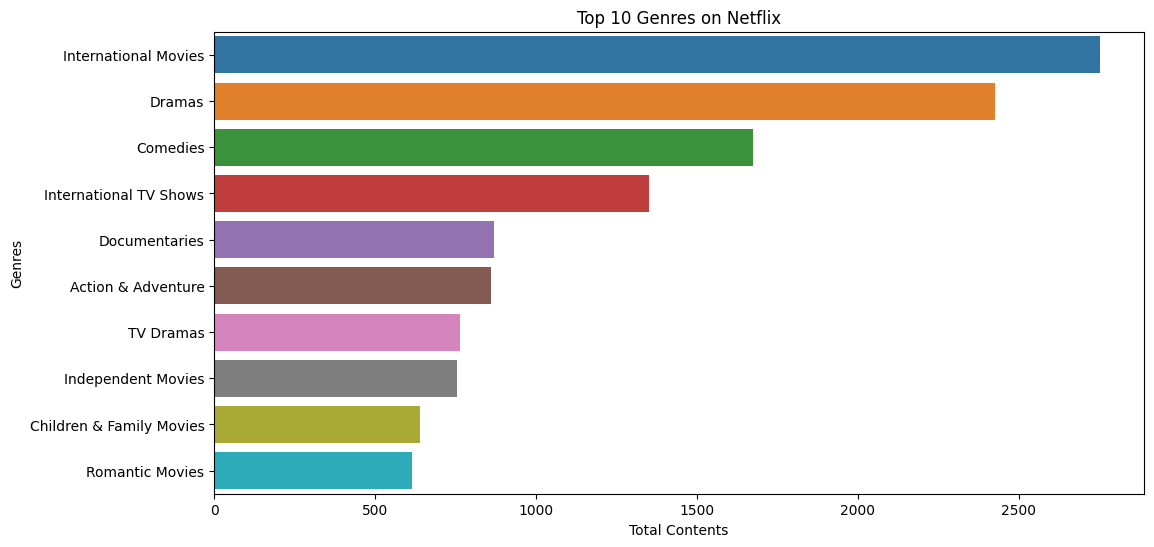

In [25]:
# Top 10 Genre on Netflix

filter_genres = new_netflix.set_index('title').listed_in.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

plt.figure(figsize=(12,6))
plt.title("Top 10 Genres on Netflix")
g = sns.countplot(y = filter_genres, order=filter_genres.value_counts().index[:10])
g.set(xlabel='Total Contents',ylabel='Genres')
plt.show()

There are 1270879 words in the combination of all description.


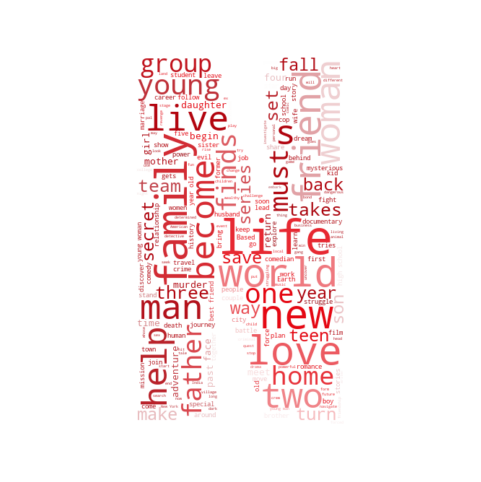

In [26]:
#Word Cloud of Netflix Contents

text = " ".join(review for review in new_netflix.description)
print ("There are {} words in the combination of all description.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["find","take"])

# Generate a word cloud image
mask = np.array(Image.open("netflix-logo.jpeg"))
wordcloud_netflix = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[6,6])
plt.imshow(wordcloud_netflix.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
#Content Based Recommendation System using Genre

new_df = new_netflix[['title','listed_in']].copy()
genre = new_df['listed_in'].str.split(",", expand=True)

all_genre = set()

for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().unique()
    all_genre.update(distinct_genre)

all_genre.remove(None)

# create item-genre matrix
item_genre_mat = new_df[['title', 'listed_in']].copy()
item_genre_mat['genres'] = item_genre_mat['listed_in'].str.lower().str.strip()

for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['listed_in','genres'], axis=1)
item_genre_mat = item_genre_mat.set_index('title')

In [28]:
corr_mat = cosine_similarity(item_genre_mat)

C:\Users\tf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [29]:
ind2name = {ind:name for ind,name in enumerate(item_genre_mat.index)}
name2ind = {v:k for v,k in ind2name.items()}

def top_k_items(item_id, top_k, corr_mat, map_name):
    
    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:][::-1] 
    top_items = [map_name[e] for e in top_items] 

    return top_items

In [30]:
index = 99
top = 5
name2ind[index]

'On the Verge'

In [31]:
similar_items = top_k_items(index,
                            top_k = top,
                            corr_mat = corr_mat,
                            map_name = ind2name)

In [32]:
# display result
print("The top " + str(top) + " similar movie to {" + name2ind[index] + "}")
display(new_df.loc[new_df['title'].isin(similar_items)])

The top 5 similar movie to {On the Verge}


,title,listed_in
848,Master of None,"TV Comedies, TV Dramas"
1063,Living with Yourself,"TV Comedies, TV Dramas"
1923,The Unicorn,"TV Comedies, TV Dramas"
2891,Gentefied,"TV Comedies, TV Dramas"
3108,Private Practice,"TV Comedies, TV Dramas"


In [33]:
## Using BERT on description to train Recommender System

data = new_netflix[['listed_in','description','title']]
X = np.array(data)
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

In [34]:
X = np.array(embeddings)
cos_sim_data = pd.DataFrame(cosine_similarity(X))

C:\Users\tf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [35]:
def give_recommendations(index,print_recommendation = False,print_genres =False):

  index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  movies_recomm =  data['title'].loc[index_recomm].values
  result = {'Movies':movies_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('The watched movie is this one: %s \n'%(data['title'].loc[index]))
    k=1
    for movie in movies_recomm:
      print('The number %i recommended movie is this one: %s \n'%(k,movie))
      k=k+1
  if print_genres==True:
    print('The genres of the watched movie is this one:\n %s \n'%(data['listed_in'].loc[index]))
    k=1
    for q in range(len(movies_recomm)):
      plot_q = data['listed_in'].loc[index_recomm[q]]
      print('The plot of the number %i recommended movie is this one:\n %s \n'%(k,plot_q))
      k=k+1
  return result

In [36]:
give_recommendations(99,True)

The watched movie is this one: On the Verge 

The number 1 recommended movie is this one: Age of Glory 

The number 2 recommended movie is this one: Being Mary Jane: The Series 

The number 3 recommended movie is this one: The Many Faces of Ito 

The number 4 recommended movie is this one: The Ultimatum 

The number 5 recommended movie is this one: Single Ladies Senior 



{'Movies': array(['Age of Glory', 'Being Mary Jane: The Series',
        'The Many Faces of Ito', 'The Ultimatum', 'Single Ladies Senior'],
       dtype=object),
 'Index': [6101, 6279, 5154, 5405, 4265]}

In [37]:
give_recommendations(99,False,True)

The genres of the watched movie is this one:
 TV Comedies, TV Dramas 

The plot of the number 1 recommended movie is this one:
 International TV Shows, Romantic TV Shows, TV Dramas 

The plot of the number 2 recommended movie is this one:
 Romantic TV Shows, TV Dramas 

The plot of the number 3 recommended movie is this one:
 International TV Shows, Romantic TV Shows, TV Dramas 

The plot of the number 4 recommended movie is this one:
 International TV Shows, TV Dramas 

The plot of the number 5 recommended movie is this one:
 International TV Shows, Romantic TV Shows, TV Dramas 



{'Movies': array(['Age of Glory', 'Being Mary Jane: The Series',
        'The Many Faces of Ito', 'The Ultimatum', 'Single Ladies Senior'],
       dtype=object),
 'Index': [6101, 6279, 5154, 5405, 4265]}

In [43]:
# save cleaned data and np model for streamlit deployment 
new_netflix.to_csv('streamlit/clean_data.csv')
np.save('streamlit/X.npy',X)